In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Univariate Statistics Feature Selection

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

# Feature selection

* Aby użyć feature selection w scikit-learn musisz wybrać test:
  * zazwyczaj **f_classif** (domyślny) dla klasyfikacji lub **f_regresja** dla regresji, 
  * oraz metodę odrzucania współrzednych na podstawie p-values testu. 

* Wszystkie metody feature selection używają wartości progowej, aby odrzucić wszystkie cechy o zbyt wysokiem p-values (co oznacza, że jest mało prawdopodobne aby były powiązane z celem). 

* Metody różnią się sposobem obliczania tego progu, przy czym najprostsze to 
  * **SelectKBest** który wybiera stałą liczbę $k$ współrzędnych 
  * **SelectPercentile**, który wybiera stały procent współrzędnych. 


# Zad 

 * Zastosuj feature selection do klasyfikacji. 

 * Aby uczynić zadanie nieco trudniejszym dodamy do danych szumu. 

 * Oczekujemy, że feature selection będzie w stanie zidentyfikować współrzedne, które nie mają wartości informacyjnej i je usunąć:

In [11]:
cancer = load_breast_cancer()
# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X_w_noise, cancer.target, random_state=0, test_size=.5)

In [13]:
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


* Jak widać, liczba współrzędnych została zmniejszona z 80 do 40 (50%). 

* Możemy dowiedzieć się, które współrzedne zostały wybrane za pomocą metody **get_support**, która zwraca maskę **Boolean** wybranych współrzednych

In [17]:
mask = select.get_support()
print(mask)

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


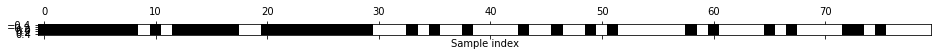

In [18]:
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.show()

* Jak widać z wizualizacji maski, większość wybranych współrzędnych to te oryginalne, a większość funkcji szumu została usunięta.

* Odzyskiwanie oryginalnych współrzednych nie jest jednak doskonałe. 

# Zad

Porównajmy wydajność regresji logistycznej dla wszystkich współrzednych i używając tylko wybranych funkcji

In [ ]:
from sklearn.linear_model import LogisticRegression
# transform test data
X_test_selected = select.transform(X_test)


W takim przypadku usunięcie szumów poprawiło wydajność, mimo że niektóre oryginalne współrzędne zostały utracone.

# Model-Based Feature Selection

* Aby użyć podejścia **model-based feature selection** musimy użyć transformatora **SelectFromModel**.

* Klasa **SelectFromModel** wybiera wszystkie współrzedne, które mają znaczenie większe niż podany próg. 

* Aby uzyskać porównywalny wynik z tym, co otrzymaliśmy dzięki podejściu **Univariate Statistics Feature Selection** użyliśmy **median** jako progu aby wybrać połowę współrzednych. 


In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel( RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")


In [25]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


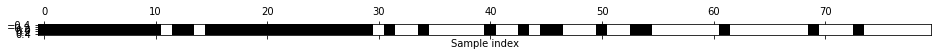

In [26]:
mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.show()

In [27]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


* Tym razem zostały wybrane wszystkie oryginalne współrzędne oprócz dwóch. 

* Ponieważ zdecydowaliśmy, aby wybrać 40 współrzednych wybrane zostaną również niektóre współrzędne szumu.

# Iterative Feature Selection

In [28]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)
select.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
  n_features_to_select=40, step=1, verbose=0)

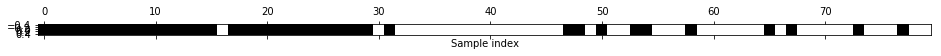

In [29]:
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.show()

* Wybór cech jest lepszy w porównaniu z wyborem opartym na jednowymiarowym i opartym na modelu, ale jedna cecha nadal jest pominięta. 

* Uruchomienie tego kodu również trwa znacznie dłużej niż w przypadku wyboru opartego na modelu, ponieważ RandomForestClassifier jest nauczony 40 razy. 

* Zbadaj dokładność modelu regresji logistycznej podczas korzystania z RFE do wyboru cech:

In [30]:
X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)
score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


In [31]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951


W tym przypadku wydajność RandomForestClassifier wykorzystywanego w RFE jest taka sama, jak w przypadku modelu regresji logistycznej na wybranych elementach. Innymi słowy, po wybraniu odpowiednich funkcji, model liniowy zachowuje siętak samo jak lasy losowe .